Import necessary libraries

In [2]:
%load_ext autoreload
%autoreload 2

from ble import get_ble_controller
from base_ble import LOG
from cmd_types import CMD
import time
import numpy as np
import matplotlib.pyplot as plt


LOG.propagate = False

**Connect to the board via BLE**

In [48]:
# Get ArtemisBLEController object
ble = get_ble_controller()

# Connect to the Artemis Device
ble.connect()

2025-04-23 15:31:06,867 | INFO     |: Looking for Artemis Nano Peripheral Device: c0:81:80:25:12:64
2025-04-23 15:31:11,170 | INFO     |: Connected to c0:81:80:25:12:64


In [49]:
ble.send_command(CMD.GET_TOF1, "")
distance1 = int(ble.receive_string(ble.uuid['RX_STRING']))
print(f"Measured distance: {distance1}")


ble.send_command(CMD.GET_TOF2, "")
distance1 = int(ble.receive_string(ble.uuid['RX_STRING']))
print(f"Measured distance: {distance1}")

Measured distance: 744
Measured distance: 277


In [51]:
control_timestamps = []
yaw = []
distance = []
distance_2 = []
motor_input = []

def extract_control_data(uuid, byte_array):
    string = byte_array.decode("utf-8") 
    split_str = string.split("|")
    control_timestamps.append(int(split_str[0]))
    yaw.append(float(split_str[1]))
    distance.append(int(split_str[2]))
    distance_2.append(int(split_str[3]))
    motor_input.append(float(split_str[4]))
    
ble.start_notify(ble.uuid['RX_STRING'], extract_control_data)

In [50]:
ble.stop_notify(ble.uuid['RX_STRING'])

KeyError: 14

In [52]:
# packet should be in the form of "yaw_control?|target_yaw_value|max_clockwise_speed|min_clockwise_speed|max_counter_clockwise_speed|min_counter_clockwise_speed|P_GAIN|D_GAIN|alpha"
import time
for i in range(0, 18):
    angle= str(20*i)
    ble.send_command(CMD.YAW_CONTROL, "1|"+ angle + "|250|40|250|60|14|0.7|0.1")
    time.sleep(1)
ble.send_command(CMD.YAW_CONTROL, "0|0|250|120|0|120|8|0.7|0.1")

In [ ]:
# ble.send_command(CMD.YAW_CONTROL, "1|90|250|120|250|120|8|0.7|0.1")


In [42]:
ble.send_command(CMD.YAW_CONTROL, "0|90|250|80|250|80|8|0.7|0.1")

In [53]:
ble.send_command(CMD.SEND_YAW_MAPPING_DATA, "")

In [54]:
print(len(control_timestamps))
# print(yaw)
print(distance)
# print(distance_2)
# print(motor_input)

18
[745, 1243, 225, 4017, 1827, 2083, 1764, 327, 323, 516, 1241, 921, 572, 654, 570, 613, 662, 796]
2025-04-23 15:32:13,855 | INFO     |: Disconnected from C0:81:80:25:12:64


In [341]:
import csv
# Combine lists into a list of rows
rows = zip(control_timestamps, yaw, distance, distance_2, motor_input)

# Specify the CSV file name
filename = ''

# Write data to CSV
with open(filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    
    # Write header (optional)
    writer.writerow(['control_timestamps', 'yaw', 'distance', 'distance_2', 'motor_input'])
    
    # Write the rows
    writer.writerows(rows)

print(f"Data saved to {filename}")

Data saved to (0,3)-run2.csv


In [ ]:
ble.send_command(CMD.STOP, "")

In [ ]:
ble.send_command(CMD.SEND_FLIP_DATA, "")

In [ ]:
print(control_timestamps)
print(distance)
print(kalman_distance)

**POST PROCESSING**

In [18]:
import matplotlib.pyplot as plt
import csv

# Initialize lists
control_timestamps = []
yaw = []
distance = []
distance_2 = []
motor_input = []
    
def load_data(coordinate : str, trial : int):
    # Specify the CSV file name
    filename = f"data/{coordinate}-run{trial}.csv"  # Use the same filename you used for saving
    
    # clear lists
    control_timestamps.clear()
    yaw.clear()
    distance.clear()
    distance_2.clear()
    motor_input.clear()
    
    # Read data from CSV
    with open(filename, mode='r', newline='') as file:
        reader = csv.reader(file)
        
        # Skip header
        next(reader)
        
        # Read rows into lists
        for i,row in enumerate(reader):
            control_timestamps.append(float(row[0]))
            yaw.append(float(row[1]))
            distance.append(float(row[2]))
            distance_2.append(float(row[3]))
            motor_input.append(float(row[4]))
    
    print("Data loaded from CSV")
    
def generate_timescale_plots(coordinate : str, trial : int):
    # First Plot: PWM and Yaw
    fig, ax1 = plt.subplots(figsize=(10, 5))
    
    # Left Y-axis: PWM
    ax1.set_title('Motor Input and Yaw vs Time')
    ax1.set_xlabel('Time (us)')
    ax1.set_ylabel('PWM Input', color='tab:blue')
    ax1.plot(control_timestamps, motor_input, label='PWM Input', color='tab:blue', linewidth=2)
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    
    # Right Y-axis: Yaw
    ax2 = ax1.twinx()
    ax2.set_ylabel('Yaw', color='tab:red')
    ax2.plot(control_timestamps, yaw, label='Yaw', color='tab:red', linewidth=2)
    ax2.tick_params(axis='y', labelcolor='tab:red')
    
    fig.tight_layout()
    plt.grid(True)
    
    plt.savefig(f"assets/{coordinate}-{trial}-motor_input_and_yaw_vs_time.png")
    
    # Second Plot: Yaw and TOF Distance
    fig, ax3 = plt.subplots(figsize=(10, 5))
    
    # Left Y-axis: Yaw
    ax3.set_title('Yaw and TOF Distance vs Time')
    ax3.set_xlabel('Time (us)')
    ax3.set_ylabel('Yaw', color='tab:green')
    ax3.plot(control_timestamps, yaw, label='Yaw', color='tab:green', linewidth=2)
    ax3.tick_params(axis='y', labelcolor='tab:green')
    
    # Right Y-axis: Distance
    ax4 = ax3.twinx()
    ax4.set_ylabel('TOF Distance', color='tab:orange')
    ax4.plot(control_timestamps, distance, label='TOF Distance', color='tab:orange', linestyle='--', linewidth=2)
    ax4.tick_params(axis='y', labelcolor='tab:orange')
    
    fig.tight_layout()
    plt.grid(True)
    
    plt.savefig(f"assets/{coordinate}/{coordinate}-{trial}-yaw_and_distance_vs_time.png")

def generate_polar_plots(coordinate : str, trial : int):
    # Convert yaw to radians if it's in degrees
    yaw_rad = np.radians(yaw)  # Assumes yaw is in degrees
    
    # Use distance as radius
    r = distance
    
    # Create polar plot
    plt.figure(figsize=(6, 6))
    ax = plt.subplot(111, projection='polar')
    
    ax.plot(yaw_rad, r, linewidth=2, label='TOF Distance')
    ax.set_title("Yaw vs TOF Distance", va='bottom', pad=30)
    ax.grid(True)
    ax.legend(loc='upper right')
    
    # plt.tight_layout()
    plt.savefig(f"assets/{coordinate}/{coordinate}-{trial}-yaw_vs_distance_polar.png")



Data loaded from CSV


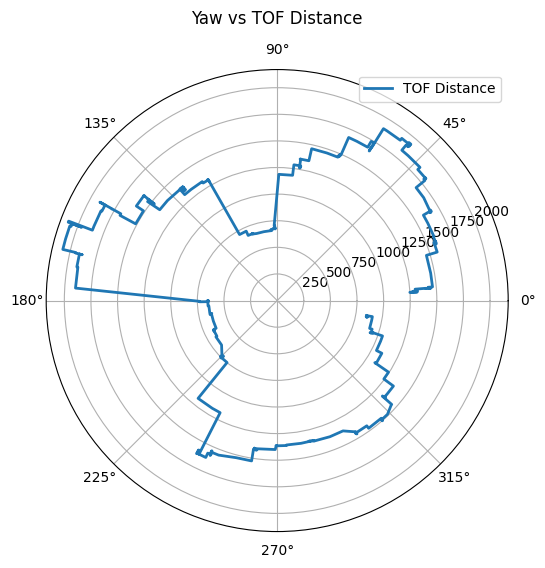

In [19]:
COORDINATE = "(0,0)"
TRIAL_RUN = 2

load_data(COORDINATE, TRIAL_RUN)
# generate_timescale_plots(COORDINATE, TRIAL_RUN)
generate_polar_plots(COORDINATE, TRIAL_RUN)

Data loaded from CSV


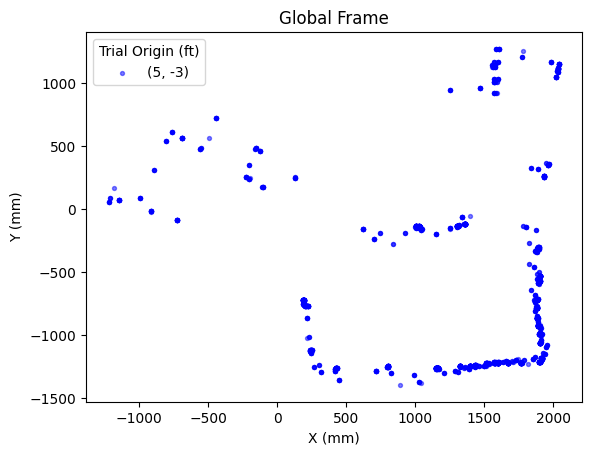

In [24]:
x_global, y_global = [], []
colors = ['blue', 'red', 'black', 'yellow','green']
# coordinates = [[5,3], [0,0], [0,3], [-3,-2], [5,-3]]
coordinates = [[5,-3]]

def transform_data(coordinate_ft: tuple, trial: int, iteration: int):
    load_data(f"({coordinate_ft[0]},{coordinate_ft[1]})", trial)

    yaw_deg = np.array(yaw)
    yaw_deg = yaw_deg - yaw_deg[0] - 8
    yaw_rad = np.deg2rad(yaw_deg)

    x_local = distance * -np.cos(yaw_rad)
    y_local = distance * -np.sin(yaw_rad)

    # Relative to origin and convert to mm
    dx = coordinate_ft[0] * 304.8
    dy = coordinate_ft[1] * 304.8

    ones = np.ones_like(x_local)
    local_frame = np.stack([x_local, y_local, ones], axis=0)

    T = np.array([
        [1, 0, dx],
        [0, 1, dy],
        [0, 0, 1]
    ])

    # Apply transformation
    global_frame = T @ local_frame

    # Store in global lists if you still want that history
    x_global.extend(global_frame[0])
    y_global.extend(global_frame[1])

    # Only plot *this run's* data
    color = colors[iteration % len(colors)]
    plt.scatter(global_frame[0], global_frame[1], color=color, s=8, alpha=0.5, label=f"({coordinate_ft[0]}, {coordinate_ft[1]})")
    
lines = [
    ((-750, 1300), (1900, 1300)),
    ((1900, 1300), (1900, -1250)),
    ((1900, -1250), (250, -1250)),
    ((250, -1250), (250, -700)),
    ((250, -700), (-250, -700)),
    ((-250, -700), (-250, -1250)),
    ((-250, -1250), (-1600, -1250)),
    ((-1600, -1250), (-1600, 200)),
    ((-1600, 200), (-750, 200)),
    ((-750, 200), (-750, 1300)),

    ((650, 500), (1400, 500)),
    ((1400, 500), (1400, -200)),
    ((1400, -200), (650, -200)),
    ((650,-200), (650, 500))
]

# plt.figure(figsize=(10, 8))

for i, coord in enumerate(coordinates):
    transform_data(coord, 2, i)

# for (p0, p1) in lines:
#     x_data = [p0[0], p1[0]]
#     y_data = [p0[1], p1[1]]
#     plt.plot(x_data, y_data, "k", linewidth=3)

# Adding the legend, title, and labels
plt.legend(title="Trial Origin (ft)")
plt.title("Global Frame")
plt.xlabel("X (mm)")
plt.ylabel("Y (mm)")

# Show the plot
plt.savefig("assets/(5,-3)-global_frame.png")
